In [281]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [337]:
df = pd.read_csv("draft_df_cleaned.csv", index_col=0)
nomc_cols = ["PLAYER", "ROOKIE", "OVERALL PICK", "YEAR", "ROTY", "ThreePA", "FTM", "OREB", "BLK", "GP", "AST", "STL", "FGPercent",\
             "ThreePPercent", "FTPercent", "PF", "HEIGHT", "WEIGHT", "CENTER", "FORWARD", "GUARD"]
df = df[nomc_cols]
cols_at_end = ['ROTY']
df = df[[c for c in df if c not in cols_at_end] 
        + [c for c in cols_at_end if c in df]]

df

,PLAYER,ROOKIE,OVERALL PICK,YEAR,ThreePA,FTM,OREB,BLK,GP,AST,...,FGPercent,ThreePPercent,FTPercent,PF,HEIGHT,WEIGHT,CENTER,FORWARD,GUARD,ROTY
0,Kwame Brown,0,1,2001,0.0,1.2,1.1,0.5,57.0,0.8,...,38.7,0.0,70.7,1.8,2.11,132.0,1,0,0,0.0
1,Pau Gasol,0,3,2001,0.1,4.1,2.9,2.1,82.0,2.7,...,51.8,20.0,70.9,2.4,2.13,113.0,1,1,0,1.0
2,Jason Richardson,0,5,2001,3.1,1.8,1.6,0.4,80.0,3.0,...,42.6,33.3,67.1,2.4,1.98,102.0,0,0,1,0.0
3,Shane Battier,0,6,2001,3.5,2.5,2.3,1.0,78.0,2.8,...,42.9,37.3,70.0,2.8,2.03,100.0,0,1,0,0.0
4,DeSagana Diop,0,8,2001,0.0,0.1,0.3,0.6,18.0,0.3,...,41.4,0.0,20.0,1.1,2.13,127.0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,Kendall Brown,1,48,2022,1.2,1.5,1.7,0.4,34.0,1.9,...,58.4,34.1,68.9,2.3,2.03,93.0,0,0,1,NaN
867,Isaiah Mobley,1,49,2022,0.9,1.2,1.5,0.6,31.0,1.0,...,47.4,28.6,52.1,2.2,2.03,108.0,0,1,0,NaN
868,Tyrese Martin,1,51,2022,3.2,1.1,1.9,0.3,33.0,1.0,...,41.8,31.1,64.8,2.1,1.98,98.0,0,0,1,NaN
869,JD Davison,1,53,2022,2.5,1.8,1.1,0.4,33.0,4.3,...,46.3,30.1,72.8,1.2,1.91,88.0,0,0,1,NaN


In [338]:
df_1 = df[df['ROOKIE']==0]
df_1_quant = df_1.select_dtypes(include=np.number).drop("ROOKIE", axis=1)
df_1_quant

,OVERALL PICK,YEAR,ThreePA,FTM,OREB,BLK,GP,AST,STL,FGPercent,FTPercent,PF,HEIGHT,WEIGHT,CENTER,FORWARD,GUARD,ROTY
0,1,2001,0.0,1.2,1.1,0.5,57.0,0.8,0.3,38.7,70.7,1.8,2.11,132.0,1,0,0,0.0
1,3,2001,0.1,4.1,2.9,2.1,82.0,2.7,0.5,51.8,70.9,2.4,2.13,113.0,1,1,0,1.0
2,5,2001,3.1,1.8,1.6,0.4,80.0,3.0,1.3,42.6,67.1,2.4,1.98,102.0,0,0,1,0.0
3,6,2001,3.5,2.5,2.3,1.0,78.0,2.8,1.6,42.9,70.0,2.8,2.03,100.0,0,1,0,0.0
4,8,2001,0.0,0.1,0.3,0.6,18.0,0.3,0.1,41.4,20.0,1.1,2.13,127.0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,53,2021,0.2,0.4,1.0,0.7,23.0,0.3,0.2,63.8,75.0,1.4,2.06,104.0,1,1,0,0.0
826,54,2021,1.3,0.4,0.9,0.2,41.0,0.5,0.2,49.6,81.8,0.7,2.06,109.0,1,1,0,0.0
827,55,2021,2.8,1.2,1.0,0.2,50.0,1.4,0.6,46.3,72.9,1.9,1.93,86.0,0,0,1,0.0
828,56,2021,0.0,0.5,0.0,0.0,2.0,0.5,0.5,0.0,50.0,0.0,1.96,84.0,0,0,1,0.0


In [339]:
df_2 = df[df['ROOKIE'] == 1]
df_2_quant = df_2.select_dtypes(include=np.number).drop("ROOKIE", axis=1)

In [340]:
dataset = df_1_quant.values
X = dataset[:, :-1]
y = dataset[:, -1]

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (556, 17) (556,)
Test (274, 17) (274,)


In [342]:
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

In [343]:
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

fs_dict = {"Features":df_1_quant.drop("ROTY", axis=1).columns, "Feature Score" : fs.scores_}
fs_df = pd.DataFrame(data=fs_dict).sort_values(by='Feature Score', ascending=False)

Feature 0: 15.433906
Feature 1: 0.391661
Feature 2: 6.252532
Feature 3: 83.854987
Feature 4: 24.473957
Feature 5: 10.406565
Feature 6: 12.276459
Feature 7: 70.573039
Feature 8: 21.775648
Feature 9: 0.002758
Feature 10: 1.695137
Feature 11: 9.575668
Feature 12: 0.259303
Feature 13: 0.175844
Feature 14: 0.007016
Feature 15: 0.372503
Feature 16: 0.356377


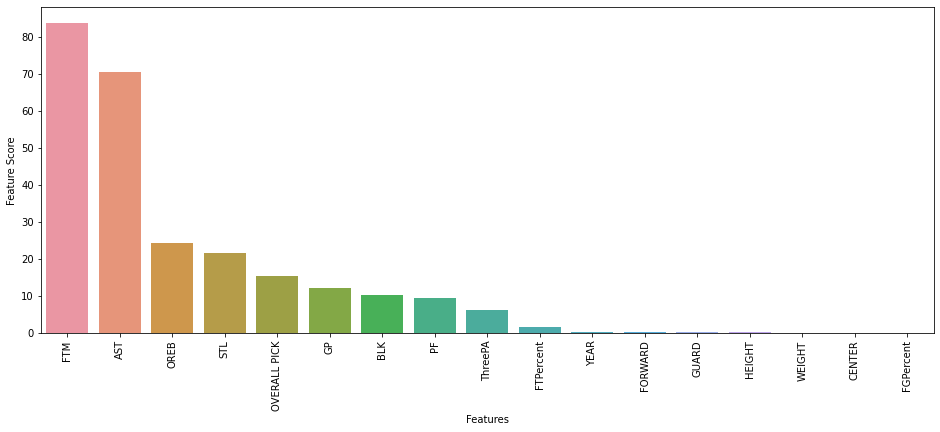

In [344]:
plt.figure(figsize=(16, 6))
bar = sns.barplot(x="Features", y="Feature Score", data=fs_df)
plt.xticks(rotation = 90)
plt.show()

In [345]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [346]:
y_hat = model.predict(X_test)

In [347]:
accuracy_score(y_test, y_hat) #high predicted accuracy due to small amount of rookie of the year winners

0.9854014598540146

In [348]:
y_hat2 = model.predict(X)

In [349]:
df_1['ROTY'] = y_hat2

C:\Users\asimp\AppData\Local\Temp/ipykernel_20472/2504518623.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['ROTY'] = y_hat2


In [350]:
df_1

,PLAYER,ROOKIE,OVERALL PICK,YEAR,ThreePA,FTM,OREB,BLK,GP,AST,...,FGPercent,ThreePPercent,FTPercent,PF,HEIGHT,WEIGHT,CENTER,FORWARD,GUARD,ROTY
0,Kwame Brown,0,1,2001,0.0,1.2,1.1,0.5,57.0,0.8,...,38.7,0.0,70.7,1.8,2.11,132.0,1,0,0,0
1,Pau Gasol,0,3,2001,0.1,4.1,2.9,2.1,82.0,2.7,...,51.8,20.0,70.9,2.4,2.13,113.0,1,1,0,1
2,Jason Richardson,0,5,2001,3.1,1.8,1.6,0.4,80.0,3.0,...,42.6,33.3,67.1,2.4,1.98,102.0,0,0,1,0
3,Shane Battier,0,6,2001,3.5,2.5,2.3,1.0,78.0,2.8,...,42.9,37.3,70.0,2.8,2.03,100.0,0,1,0,0
4,DeSagana Diop,0,8,2001,0.0,0.1,0.3,0.6,18.0,0.3,...,41.4,0.0,20.0,1.1,2.13,127.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,Charles Bassey,0,53,2021,0.2,0.4,1.0,0.7,23.0,0.3,...,63.8,0.0,75.0,1.4,2.06,104.0,1,1,0,0
826,Sandro Mamukelashvili,0,54,2021,1.3,0.4,0.9,0.2,41.0,0.5,...,49.6,42.3,81.8,0.7,2.06,109.0,1,1,0,0
827,Aaron Wiggins,0,55,2021,2.8,1.2,1.0,0.2,50.0,1.4,...,46.3,30.4,72.9,1.9,1.93,86.0,0,0,1,0
828,Scottie Lewis,0,56,2021,0.0,0.5,0.0,0.0,2.0,0.5,...,0.0,0.0,50.0,0.0,1.96,84.0,0,0,1,0


In [351]:
df_TESTPRED = pd.DataFrame(df_1['PLAYER'][df_1['ROTY']==1])
df_TESTPRED

,PLAYER
1,Pau Gasol
36,Amar'e Stoudemire
94,Dwight Howard
95,Emeka Okafor
119,Chris Paul
156,Brandon Roy
226,Derrick Rose
259,Patrick Ewing
268,Blake Griffin
305,John Wall


In [352]:
df_TESTPRED.to_csv("ROTYTESTPRED.csv")

In [353]:
df_actual = pd.read_csv("roty.csv")
df_actual

,Season,Lg,Player,Voting,Age,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,-9999
0,2021-22,NBA,Scottie Barnes,(V),20,TOR,74,35.4,15.3,7.5,3.5,1.1,0.7,0.492,0.301,0.735,6.6,0.122,barnesc01
1,2020-21,NBA,LaMelo Ball,(V),19,CHO,51,28.8,15.7,5.9,6.1,1.6,0.4,0.436,0.352,0.758,2.8,0.093,ballla01
2,2019-20,NBA,Ja Morant,(V),20,MEM,67,31.0,17.8,3.9,7.3,0.9,0.3,0.477,0.335,0.776,3.8,0.088,moranja01
3,2018-19,NBA,Luka Dončić,(V),19,DAL,72,32.2,21.2,7.8,6.0,1.1,0.3,0.427,0.327,0.713,4.9,0.101,doncilu01
4,2017-18,NBA,Ben Simmons,(V),21,PHI,81,33.7,15.8,8.1,8.2,1.7,0.9,0.545,0.000,0.560,9.2,0.162,simmobe01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,1951-52,NBA,Bill Tosheff (Tie) *,NaN,25,INO,65,31.6,9.4,3.3,3.4,NaN,NaN,0.327,NaN,0.824,2.9,0.068,toshebi01
75,1950-51,NBA,Paul Arizin *,NaN,22,PHW,65,NaN,17.2,9.8,2.1,NaN,NaN,0.407,NaN,0.793,13.7,NaN,arizipa01
76,1949-50,NBA,Alex Groza *,NaN,23,INO,64,NaN,23.4,NaN,2.5,NaN,NaN,0.478,NaN,0.729,17.9,NaN,grozaal01
77,1948-49,BAA,Howie Shannon *,NaN,25,PRO,55,NaN,13.4,NaN,2.3,NaN,NaN,0.364,NaN,0.804,3.4,NaN,shannho01


In [354]:
correct = 0
wrong = 0
pred_list = df_TESTPRED["PLAYER"].tolist()
actual_list = df_actual["Player"].tolist()
actual_list[3] = 'Luka Doncic'
for p in pred_list:
    if p in actual_list:
        correct +=1
    else:
        wrong +=1
print('correct:', correct)
print('wrong:',wrong) #the one wrong prediction was steph curry who finished second in mvp voting
                      #missed roty winners were typically in a competetive draft such as 2015-2016 and 2003-2004

correct: 18
wrong: 2
